In [55]:
#conda install -c conda-forge libta-lib
#conda install -c conda-forge ta-lib

In [56]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, concatenate, Conv1D, Reshape, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import keras_tuner as kt
from tensorflow.keras.saving import register_keras_serializable

In [57]:
# Calculate the date range for the last year
end_date = datetime.today()
start_date = end_date - timedelta(days=1*365)

# Fetch stock data
ticker = 'NVDA'
try:
    df = yf.download(ticker, start=start_date, end=end_date)
except Exception as e:
    print(f"Error fetching data: {e}")
    df = pd.DataFrame()
# Rename columns for convenience and compatibility with pandas_ta
df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
df['mid'] = (df['high'] + df['low']) / 2
df['target'] = df['mid'].shift(-1)

df.index = pd.to_datetime(df.index)

[*********************100%%**********************]  1 of 1 completed


In [58]:
# Initialize the MinMaxScaler
target_scaler = StandardScaler()
mid_scaler = StandardScaler()
macd_scaler = StandardScaler()
signal_line_scaler = StandardScaler()
macd_hist_scaler = StandardScaler()
upper_band_scaler = StandardScaler()
middle_band_scaler = StandardScaler()
lower_scaler = StandardScaler()
ema_scaler = StandardScaler()
obv_scaler = StandardScaler()

# Fit and transform the 'mid' column
df['mid_scaled'] = mid_scaler.fit_transform(df['mid'].values.reshape(-1, 1))
df['target_scaled'] = target_scaler.fit_transform(df['target'].values.reshape(-1, 1))

# Calculate technical indicators
df['macd'], df['signal_line'], df['macd_hist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['macd_scaled'] = macd_scaler.fit_transform(df['macd'].values.reshape(-1, 1))
df['signal_line_scaled'] = signal_line_scaler.fit_transform(df['signal_line'].values.reshape(-1, 1))
df['macd_hist_scaled'] = macd_hist_scaler.fit_transform(df['macd_hist'].values.reshape(-1, 1))

df['rsi'] = talib.RSI(df['close'], timeperiod=14)
df['rsi_scaled'] = df['rsi'] / 100

df['adx'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['adx_scaled'] = df['adx'] / 100

df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['upper_band_scaled'] = upper_band_scaler.fit_transform(df['upper_band'].values.reshape(-1, 1))
df['middle_band_scaled'] = middle_band_scaler.fit_transform(df['middle_band'].values.reshape(-1, 1))
df['lower_band_scaled'] = lower_scaler.fit_transform(df['lower_band'].values.reshape(-1, 1))

df['ema'] = talib.EMA(df['close'], timeperiod=20)
df['ema_scaled'] = ema_scaler.fit_transform(df['ema'].values.reshape(-1, 1))

df['obv'] = talib.OBV(df['close'], df['volume'])
df['obv_scaled'] = obv_scaler.fit_transform(df['obv'].values.reshape(-1, 1))

# Get all candlestick pattern functions
all_functions = talib.get_function_groups()
candlestick_patterns = all_functions['Pattern Recognition']
patterns = {pattern: getattr(talib, pattern) for pattern in candlestick_patterns}

# Apply each pattern function to the DataFrame and sum the results
df['pattern_sum'] = 0
for pattern_name, pattern_func in patterns.items():
    df[pattern_name] = pattern_func(df['open'], df['high'], df['low'], df['close'])
    df['pattern_sum'] += df[pattern_name]

# Normalize the summed pattern values to be within the range of -1 to 1
df['pattern_sum'] = df['pattern_sum'].apply(lambda x: np.clip(x, -100, 100) / 100)

df.to_csv('before.csv', index=True)

In [59]:
# Get the current working directory
current_dir = os.getcwd()
checkpoint_path_combined = os.path.join(current_dir, 'best_combined_model.keras')
checkpoint_path_mid_only = os.path.join(current_dir, 'best_mid_only_model.keras')

# Create metric objects outside the function
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Custom F1 Score metric
def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1 * 100

# Custom Directional Accuracy metric
def directional_accuracy(y_true, y_pred):
    y_true = K.cast(y_true, dtype=tf.float32)
    y_pred = K.cast(y_pred, dtype=tf.float32)
    direction_true = K.sign(y_true[1:] - y_true[:-1])
    direction_pred = K.sign(y_pred[1:] - y_pred[:-1])
    correct_directions = K.sum(K.cast(K.equal(direction_true, direction_pred), dtype=tf.float32))
    total = K.cast(K.shape(y_true)[0] - 1, dtype=tf.float32)
    result = (correct_directions / total) 
    return result

# Custom combined metric
@tf.keras.utils.register_keras_serializable()
def combined_metric(y_true, y_pred):
    #direction_acc = directional_accuracy(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mse = mse_metric(y_true, y_pred)
    mse = 1 - mse
    mse = mse * 100
    
    return  0.5 * mse + 0.5 * f1

# Define the time steps
time_steps = 5

# Function to create sequences
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

In [60]:
# Create sequences for the target variable
y = df['target_scaled']
y = y[time_steps:]
y = y[:-1]

x_data = df['mid_scaled']
x_data = x_data[:-1]
x = create_sequences(x_data, time_steps)
x = x.reshape((x.shape[0], x.shape[1], 1))

split_index1 = int(0.8 * len(x))
x_train, x_val = x[:split_index1], x[split_index1:]
y_train, y_val = y[:split_index1], y[split_index1:]

In [61]:
def build_mid_only_model(hp):
    input_layer_mid_only = Input(shape=(time_steps, 1))
    lstm_units_mid_only = hp.Int('lstm_units_mid_only', min_value=32, max_value=128, step=32)
    lstm_layer_mid_only = Bidirectional(LSTM(lstm_units_mid_only, return_sequences=False))(input_layer_mid_only)
    dropout_mid_only = hp.Float('dropout_mid_only', min_value=0.1, max_value=0.5, step=0.1)
    dropout_layer_mid_only = Dropout(dropout_mid_only)(lstm_layer_mid_only)
    final_output_mid_only = Dense(1)(dropout_layer_mid_only)

    model = Model(inputs=input_layer_mid_only, outputs=final_output_mid_only)
    #model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[combined_metric])
    return model
    
# Define the ModelCheckpoint callback
checkpoint_callback_mid_only = ModelCheckpoint(
    filepath=checkpoint_path_mid_only,
    save_best_only=True,
    monitor='combined_metric',
    mode='max'
)
# Initialize the tuner for the mid-only model
tuner_mid_only = kt.RandomSearch(
    build_mid_only_model,
    #objective='val_loss',
    kt.Objective('combined_metric', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory=ticker.replace(" ", "_") + "_tuner", 
    project_name='lstm_mid_only_tuning'
)

# Start the tuning process
tuner_mid_only.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[checkpoint_callback_mid_only])

Trial 1 Complete [00h 02m 12s]
combined_metric: 68.96329727172852

Best combined_metric So Far: 68.96329727172852
Total elapsed time: 00h 02m 12s


In [62]:
mid_data = df['mid_scaled'].values
macd_data = df['macd_scaled'].values
rsi_data = df['rsi_scaled'].values
adx_data = df['adx_scaled'].values
upper_band_data = df['upper_band_scaled'].values
middle_band_data = df['middle_band_scaled'].values
lower_band_data = df['lower_band_scaled'].values
ema_data = df['ema_scaled'].values
obv_data = df['obv_scaled'].values
pattern_data = df['pattern_sum'].values
mid_y =  df['target_scaled'].values

mid_data = mid_data[:-1]
macd_data = macd_data[:-1]
rsi_data = rsi_data[:-1]
adx_data = adx_data[:-1]
upper_band_data = upper_band_data[:-1]
middle_band_data = middle_band_data[:-1]
lower_band_data = lower_band_data[:-1]
ema_data = ema_data[:-1]
obv_data = obv_data[:-1]
pattern_data = pattern_data[:-1]
mid_y = mid_y[:-1]

trim_length = 33 # macd 1 to 33 are null
mid_data = mid_data[trim_length:]
macd_data = macd_data[trim_length:]
rsi_data = rsi_data[trim_length:]
adx_data = adx_data[trim_length:]
upper_band_data = upper_band_data[trim_length:]
middle_band_data = middle_band_data[trim_length:]
lower_band_data = lower_band_data[trim_length:]
ema_data = ema_data[trim_length:]
obv_data = obv_data[trim_length:]
pattern_data = pattern_data[trim_length:]
mid_y = mid_y[trim_length:]
mid_y = mid_y[time_steps:]

In [63]:
# Create sequences for each indicator
mid_X = create_sequences(mid_data, time_steps)
macd_X = create_sequences(macd_data, time_steps)
rsi_X = create_sequences(rsi_data, time_steps)
adx_X = create_sequences(adx_data, time_steps)

# Stack the band data along the feature axis
bbands_X = np.stack([upper_band_data, middle_band_data, lower_band_data], axis=-1)
bbands_X = create_sequences(bbands_X, time_steps)

ema_X = create_sequences(ema_data, time_steps)
obv_X = create_sequences(obv_data, time_steps)
pattern_X = create_sequences(pattern_data, time_steps)

# Reshape sequences to be [samples, time steps, features]
mid_X = mid_X.reshape((mid_X.shape[0], mid_X.shape[1], 1))
macd_X = macd_X.reshape((macd_X.shape[0], macd_X.shape[1], 1))
rsi_X = rsi_X.reshape((rsi_X.shape[0], rsi_X.shape[1], 1))
adx_X = adx_X.reshape((adx_X.shape[0], adx_X.shape[1], 1))
bbands_X = bbands_X.reshape((bbands_X.shape[0], bbands_X.shape[1], bbands_X.shape[2]))
ema_X = ema_X.reshape((ema_X.shape[0], ema_X.shape[1], 1))
obv_X = obv_X.reshape((obv_X.shape[0], obv_X.shape[1], 1))
pattern_X = pattern_X.reshape((pattern_X.shape[0], pattern_X.shape[1], 1))

# Split the data into training and validation sets
split_index2 = int(0.8 * len(mid_X))
mid_X_train, mid_X_val = mid_X[:split_index2], mid_X[split_index2:]
macd_X_train, macd_X_val = macd_X[:split_index2], macd_X[split_index2:]
rsi_X_train, rsi_X_val = rsi_X[:split_index2], rsi_X[split_index2:]
adx_X_train, adx_X_val = adx_X[:split_index2], adx_X[split_index2:]
bbands_X_train, bbands_X_val = bbands_X[:split_index2], bbands_X[split_index2:]
ema_X_train, ema_X_val = ema_X[:split_index2], ema_X[split_index2:]
obv_X_train, obv_X_val = obv_X[:split_index2], obv_X[split_index2:]
pattern_X_train, pattern_X_val = pattern_X[:split_index2], pattern_X[split_index2:]
y_combined_train, y_combined_val = mid_y[:split_index2], mid_y[split_index2:]

In [64]:
# Define the combined model adjust
def build_combined_model(hp):
    inputs = []
    output_layers = []

    indicators = [{'patterns': 'conv1d'}, {'mid': 'lstm'}]
   
    for d in indicators:
        for key, value in d.items():
            input_layer = Input(shape=(time_steps, 1), name=f'input_{key}')
            inputs.append(input_layer)
            for key, value in d.items():
                if value == 'lstm':
                    lstm_units = hp.Int(f'lstm_units_{key}', min_value=32, max_value=128, step=32)
                    model_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(input_layer)
                    dropout_rate = hp.Float(f'dropout_{key}', min_value=0.1, max_value=0.5, step=0.1)
                    dropout_layer = Dropout(dropout_rate)(model_layer)
                    output_layer = Flatten()(dropout_layer) 
                    output_layers.append(output_layer)
                    
                elif value == 'conv1d':
                    filters = hp.Int(f'conv_filters_{key}', min_value=8, max_value=32, step=8)
                    kernel_size = hp.Int(f'kernel_size_{key}', min_value=3, max_value=5, step=1)
                    model_layer = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_layer)
                    dropout_rate = hp.Float(f'dropout_{key}', min_value=0.1, max_value=0.5, step=0.1)
                    dropout_layer = Dropout(dropout_rate)(model_layer)  
                    output_layer = Flatten()(dropout_layer) 
                    output_layers.append(output_layer) 
                            
    combined = concatenate(output_layers)
    final_output = Dense(1, activation='linear', name='final_output')(combined)

    model = Model(inputs=inputs, outputs=final_output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[combined_metric])
    return model

# Define the ModelCheckpoint callback
checkpoint_callback_combined = ModelCheckpoint(
    filepath=checkpoint_path_combined,
    save_best_only=True,
    monitor='combined_metric',
    mode='max'
)

# Initialize the tuner for the combined model
tuner_combined = kt.RandomSearch(
    build_combined_model,
    #objective='val_loss',
    objective= kt.Objective('combined_metric', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory=ticker.replace(" ", "_") + "_tuner", 
    project_name='lstm_combined_tuning'
)

# Prepare the input data for the model adjust
X_combined_train = [pattern_X_train, mid_X_train]
X_combined_val = [pattern_X_val, mid_X_val]

# Run the hyperparameter search for the combined model
tuner_combined.search(X_combined_train, y_combined_train, epochs=50, validation_data=(X_combined_val, y_combined_val), callbacks=[checkpoint_callback_combined])

Trial 1 Complete [00h 02m 49s]
combined_metric: 70.42593994140626

Best combined_metric So Far: 70.42593994140626
Total elapsed time: 00h 02m 49s


In [65]:
# Load the best models
best_mid_only_model = load_model('best_mid_only_model.keras')
best_combined_model = load_model('best_combined_model.keras')


In [66]:
# Predict using the best models
y_pred_mid_only = best_mid_only_model.predict(x)
X_combined = [pattern_X, mid_X]
y_pred_combined = best_combined_model.predict(X_combined)

y_pred_mid_only_unscaled = target_scaler.inverse_transform(y_pred_mid_only)
y_pred_combined_unscaled = target_scaler.inverse_transform(y_pred_combined)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [67]:
# Save the updated DataFrame to a CSV file
df.to_csv('after.csv', index=True)

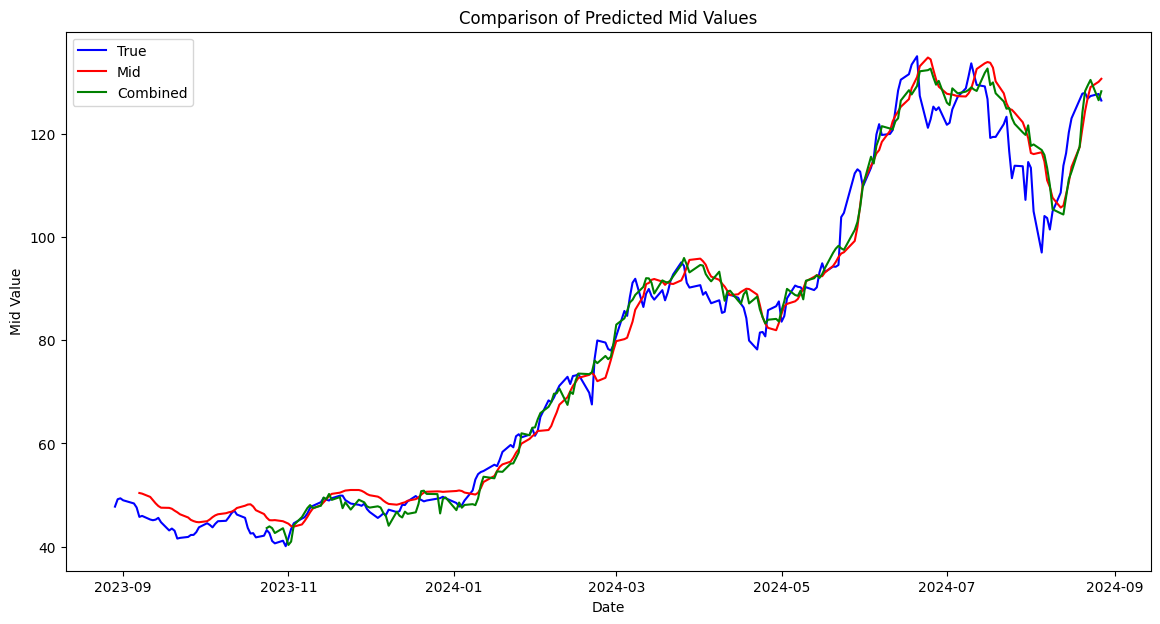

In [68]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['mid'], label='True', color='blue') 
plt.plot(df.index[6:], y_pred_mid_only_unscaled, label='Mid', color='red')
plt.plot(df.index[39:], y_pred_combined_unscaled, label='Combined', color='green')
plt.xlabel('Date')
plt.ylabel('Mid Value')
plt.title('Comparison of Predicted Mid Values')
plt.legend()
plt.show()


In [69]:
mse_mid_only = mse_metric(y, y_pred_mid_only)
mse_combined = mse_metric(mid_y, y_pred_combined)

f1_mid_only = f1_score(y, y_pred_mid_only) 
f1_combined = f1_score(mid_y, y_pred_combined)

directional_accuracy_mid_only = directional_accuracy(y, y_pred_mid_only)
directional_accuracy_combined = directional_accuracy(mid_y, y_pred_combined)

print(f"Mid-Only Model - MSE: {mse_mid_only}, F1: {f1_mid_only}%, Directional Accuracy: {directional_accuracy_mid_only}%")
print(f"Combined Model - MSE: {mse_combined}, F1: {f1_combined}%, Directional Accuracy: {directional_accuracy_combined}%")

Mid-Only Model - MSE: 0.06619413197040558, F1: 48.98828125%, Directional Accuracy: 127.97541046142578%
Combined Model - MSE: 0.06615278124809265, F1: 48.99137878417969%, Directional Accuracy: 109.17535400390625%


In [70]:
x_data = df['mid_scaled']
x_data = x_data[:-1]
x = create_sequences(x_data, time_steps)
x = x.reshape((x.shape[0], x.shape[1], 1))

mid_data = df['mid_scaled'].values
macd_data = df['macd_scaled'].values
rsi_data = df['rsi_scaled'].values
adx_data = df['adx_scaled'].values
upper_band_data = df['upper_band_scaled'].values
middle_band_data = df['middle_band_scaled'].values
lower_band_data = df['lower_band_scaled'].values
ema_data = df['ema_scaled'].values
obv_data = df['obv_scaled'].values
pattern_data = df['pattern_sum'].values

mid_data = mid_data[trim_length:]
macd_data = macd_data[trim_length:]
rsi_data = rsi_data[trim_length:]
adx_data = adx_data[trim_length:]
upper_band_data = upper_band_data[trim_length:]
middle_band_data = middle_band_data[trim_length:]
lower_band_data = lower_band_data[trim_length:]
ema_data = ema_data[trim_length:]
obv_data = obv_data[trim_length:]
pattern_data = pattern_data[trim_length:]

# Create sequences for each indicator
mid_X = create_sequences(mid_data, time_steps)
macd_X = create_sequences(macd_data, time_steps)
rsi_X = create_sequences(rsi_data, time_steps)
adx_X = create_sequences(adx_data, time_steps)

# Stack the band data along the feature axis
bbands_X = np.stack([upper_band_data, middle_band_data, lower_band_data], axis=-1)
bbands_X = create_sequences(bbands_X, time_steps)

ema_X = create_sequences(ema_data, time_steps)
obv_X = create_sequences(obv_data, time_steps)
pattern_X = create_sequences(pattern_data, time_steps)

# Reshape sequences to be [samples, time steps, features]
mid_X = mid_X.reshape((mid_X.shape[0], mid_X.shape[1], 1))
macd_X = macd_X.reshape((macd_X.shape[0], macd_X.shape[1], 1))
rsi_X = rsi_X.reshape((rsi_X.shape[0], rsi_X.shape[1], 1))
adx_X = adx_X.reshape((adx_X.shape[0], adx_X.shape[1], 1))
bbands_X = bbands_X.reshape((bbands_X.shape[0], bbands_X.shape[1], bbands_X.shape[2]))
ema_X = ema_X.reshape((ema_X.shape[0], ema_X.shape[1], 1))
obv_X = obv_X.reshape((obv_X.shape[0], obv_X.shape[1], 1))
pattern_X = pattern_X.reshape((pattern_X.shape[0], pattern_X.shape[1], 1))

# Predict using the best models
y_pred_mid_only = best_mid_only_model.predict(x)
X_combined = [pattern_X, mid_X]
y_pred_combined = best_combined_model.predict(X_combined)

y_pred_mid_only_unscaled = target_scaler.inverse_transform(y_pred_mid_only)
y_pred_combined_unscaled = target_scaler.inverse_transform(y_pred_combined)


last_value_mid_only = y_pred_mid_only_unscaled[-1][0]
last_value_combined = y_pred_combined_unscaled[-1][0]

print("Last value from y_pred_mid_only_unscaled:", last_value_mid_only)
print("Last value from y_pred_combined_unscaled:", last_value_combined)

current_price_last_value = df['mid'].iloc[-1]
print("Last value of current_price (mid):", current_price_last_value)

# Calculate profit
profit_mid_only = last_value_mid_only - current_price_last_value
profit_combined = last_value_combined - current_price_last_value

# Calculate percentage change
percentage_change_mid_only = (profit_mid_only / current_price_last_value) * 100
percentage_change_combined = (profit_combined / current_price_last_value) * 100

print("Profit (Mid Only Model):", profit_mid_only)
print("Percentage Change (Mid Only Model): {:.2f}%".format(percentage_change_mid_only))
print("Profit (Combined Model):", profit_combined)
print("Percentage Change (Combined Model): {:.2f}%".format(percentage_change_combined))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Last value from y_pred_mid_only_unscaled: 130.75848
Last value from y_pred_combined_unscaled: 128.23242
Last value of current_price (mid): 126.53999710083008
Profit (Mid Only Model): 4.218486785888672
Percentage Change (Mid Only Model): 3.33%
Profit (Combined Model): 1.6924247741699219
Percentage Change (Combined Model): 1.34%
